In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model_2d import pde_hotelling
from numba import njit

PDE:

\begin{align*}
0 = \max_{\tilde{e}}\min_{h}\min_{\pi_i^c, \sum_{i=1}^n \pi^c_i=1} &  -  \frac{\partial V}{\partial b}\delta b - \ell \tilde{e} + \delta b \eta \log \tilde{e} \\
& + \frac{\partial V}{\partial y}\tilde{e}(\sum_{i=1}^n\pi_i^c\theta_i+\sigma_y\cdot h) + \frac{1}{2}\frac{\partial^2 V}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 \\
& + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\tilde{e}(\sum_{i=1}^n\pi_i^c\theta_i+\sigma_y\cdot h) \\
& +  b \left(\frac{\xi_m}{2}h^\prime h \right) + b \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}

The FOC of $h$ gives:
$$
h^* = -\frac{G(y,b)\tilde{e}\sigma_y}{b\xi_m}
$$

where
$$
G(y, b) = \frac{\partial V}{\partial y} + b (\eta-1) \left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]
$$

Plug in $h^*$ and the simplified PDE is:

\begin{align*}
0 = \max_{\tilde{e}}\min_{\pi_i^c, \sum_{i=1}^n \pi^c_i=1} &  -  \frac{\partial V}{\partial b}\delta b - \ell \tilde{e} + \delta b \eta \log \tilde{e} \\
& + \frac{\partial V}{\partial y}\tilde{e}\sum_{i=1}^n\pi_i^c\theta_i + \frac{1}{2}\frac{\partial^2 V}{(\partial y)^2}|\sigma_y|^2(\tilde{e})^2 \\
& + b(\eta-1)\left[\gamma_1 + \gamma_2 y + \gamma_2^+\boldsymbol{1}_{y\geq \bar{y}}(y-\bar{y})\right]\tilde{e}\sum_{i=1}^n\pi_i^c\theta_i \\
&  + b \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c) - \frac{G^2(y,b)\tilde{e}^2\sigma_y^2}{2b\xi_m}
\end{align*}


The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\left(\sum_{i=1}^n\pi^c_i \theta_i G(y)-\ell\right) - \sqrt{\left(\sum_{i=1}^n \pi_i^c \theta_iG(y, b)-\ell\right)^2-4b\delta \eta |\sigma_y|^2\left(\frac{\partial^2 V}{(\partial y)^2}-\frac{G^2(y,b)}{b\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{\partial^2 V}{(\partial y)^2}-\frac{G^2(y,b)}{b\xi_{1,m}}\right)}
$$

In addition, the FOC of $\pi^c$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{b\xi_a}G(y,b)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

In [18]:
ξ_1m = 1000.
ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = 0*.5 + .0197*2*.5

n_y = 50
y_min = 1e-10
y_max = 5
y_grid = np.linspace(y_min, y_max, n_y)

n_b = 20
b_min = 1./n_b
b_max = 1.
b_grid = np.linspace(b_min, b_max, n_b)

model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p, y_bar) 

ell = 1e-12
Δ_ell = 1e-13
model_res = pde_hotelling(y_grid, b_grid, ell=ell,
                          model_paras=model_paras, v0=None, ϵ=.5,
                          tol=1e-8, max_iter=1_000, print_all=False)
model_res_right = pde_hotelling(y_grid, b_grid, ell=ell+Δ_ell,
                          model_paras=model_paras, v0=None, ϵ=.5,
                          tol=1e-8, max_iter=1_000, print_all=False)

Converged. Total iteration 1000: LHS Error: 2.1189207025963663e-06; RHS Error 4.806397564755525e-06
Converged. Total iteration 1000: LHS Error: 2.1189210838296058e-06; RHS Error 4.80639770441345e-06


In [19]:
ψ_ell = model_res['v0'][:, -1]
ψ_ell_right = model_res_right['v0'][:, -1]
dψ_ell = (ψ_ell_right-ψ_ell)/Δ_ell
r = -dψ_ell

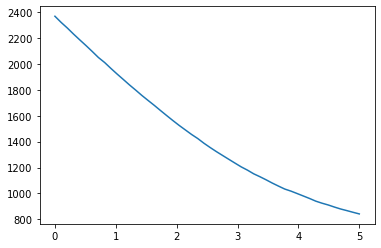

In [20]:
plt.plot(y_grid, r)